In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from matplotlib import rcParams

plt.rcParams['font.sans-serif'] = ['SimHei']  # 防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

TimesSong = FontProperties(fname="C:\\Users\\Linzy\\Desktop\\TimesSong.ttf")
font_manager.fontManager.addfont("C:\\Users\\Linzy\\Desktop\\TimesSong.ttf")

# 全局设置字体及大小，设置公式字体即可
config = {
    "mathtext.fontset": 'stix',
    "font.family": 'serif',
    "font.serif": ['TimesSong'],
    'axes.unicode_minus': False,  # 处理负号，即-号
    "font.size": 12
}

rcParams.update(config)

In [2]:
fulidf=pd.read_excel('./xianClimate.xlsx')
fulidf=fulidf[fulidf['年(年)'].isin(range(2009,2023,1))]
fulidf=fulidf.replace(999999,np.nan)
fulidf=fulidf.replace(999990.0,np.nan)
fulidf=fulidf.replace(999998.0,np.nan)

In [3]:
staname=fulidf['站名'].drop_duplicates().reset_index(drop=True)

In [4]:
import json
with open("D:\\_work\\project\\HZYWsystem\\statics\\webgis\\map\\qyqxsta.json") as f:
    qydata=json.load(f)
with open("D:\\_work\\project\\HZYWsystem\\statics\\webgis\\map\\guoqxsta.json") as f:
    guojiadata=json.load(f)

In [ ]:
qyname=list(qydata['A3'].values())
qyname

In [ ]:
lonqy=list(qydata['A5'].values())
lonqy

In [ ]:
latqy=list(qydata['A6'].values())
latqy

In [9]:
def backTrrain(fulidf,staname_i):    
    fulidf1=fulidf[fulidf['站名']==staname_i].reset_index()
    T=fulidf1['平均气温(摄氏度(℃))'].mean(skipna=True)
    ymin=fulidf1['年(年)'].min()
    ymax=fulidf1['年(年)'].max()
    rainlist=[]
    for i in range(ymin,ymax+1,1):
        rainlist.append(fulidf1[fulidf1['年(年)']==i]['20-20时降水量(毫米)'].sum())
    rain=np.mean(rainlist).round(2)
    return T,rain

In [ ]:
alllist=[]
for i in staname:
    T,rain=backTrrain(fulidf,i)
    alllist.append([i,T,rain])
alllist

In [ ]:
fulidf1=fulidf[fulidf['站名']=='富川福利气象观测站'].reset_index()
fulidf1['年(年)'].min(),fulidf1['年(年)'].max()

In [12]:
fcdatadf=pd.DataFrame(alllist,columns=['staname', 'T', 'rain'])

In [ ]:
indexsta=[]
for i in fcdatadf['staname'][1:]:
    indexsta.append(qyname.index(i))
indexsta

In [ ]:
lonlist=[]
latlist=[]
lonlist.append(list(guojiadata['A5'].values())[0])
latlist.append(list(guojiadata['A6'].values())[0])
for i in indexsta:
    lonlist.append(lonqy[i])
    latlist.append(latqy[i])
lonlist

In [ ]:
fcdatadf['lon']=lonlist
fcdatadf['lat']=latlist
fcdatadf

In [16]:
Tfc=fcdatadf[fcdatadf['T']>0]

# 插值

In [17]:
from scipy.interpolate import griddata
from metpy.interpolate import inverse_distance_to_grid
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# 插值
from pykrige import OrdinaryKriging
### 白化关键包
import geopandas as gpd
from matplotlib.path import Path
from cartopy.mpl.patch import geos_to_path

In [ ]:
shp=gpd.read_file(r"D:\_work\mapdata\fuchuan\geojson.shp",encoding='UTF-8')
shp

In [ ]:
np.array(list(shp['geometry'][0].exterior.coords))[:,1].min()

In [20]:
def add_north(ax, labelsize=12, loc_x=0.05, loc_y=1.07, width=0.03, height=0.045, pad=0.14):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)


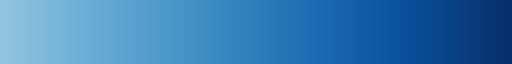

In [21]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        "trunc({n},{a:.2f},{b:.2f})".format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap
cmap = plt.get_cmap("Blues")
trunc_cmap1 = truncate_colormap(cmap, 0.4, 1)
trunc_cmap1

In [ ]:
extent=[110.99778373704645,111.56357963548395,24.461242833894357,25.129462933561904]
lon_target = np.arange(111.08795,111.515133,0.001)
lat_target = np.arange(24.593434,25.18245,0.001)
x_t, y_t = np.meshgrid(lon_target, lat_target)
# model=OrdinaryKriging(fcdatadf['lon'].values,fcdatadf['lat'].values,fcdatadf['rain'].values,variogram_model='gaussian',nlags=500)
model=OrdinaryKriging(fcdatadf['lon'].values,fcdatadf['lat'].values,fcdatadf['rain'].values,variogram_model='linear',nlags=100)
ds1,ds2=model.execute('grid',lon_target,lat_target)
ds1=np.round(ds1,3)

fig=plt.figure(figsize=(9,16))
ax=fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax1=fig.add_axes([0.11,0.20,0.04,0.15])
ax2=fig.add_axes([0.79,0.75,0.05*(16/9),0.05])
ax2.set_axis_off()
ax3=fig.add_axes([0.59,0.195,0.18*(16/9),0.025])
ax3.set_axis_off()
# arrimg=plt.imread(r"C:\Users\Linzy\Desktop\chinaclimate.png")
arrimg=plt.imread(r"C:\Users\Linzy\Desktop\图片231201(1)(1).png")
# arrimg1=plt.imread(r"C:\Users\Linzy\Desktop\bili.png")
arrimg1=plt.imread(r"C:\Users\Linzy\Downloads\IMG_202312015885_719x126.png")
ax2.imshow(arrimg)
ax3.imshow(arrimg1)
ax.add_geometries(Reader(r"D:\_work\mapdata\fuchuan\geojson.shp").geometries(),ccrs.PlateCarree(),facecolor='none', edgecolor='b', linewidth=0.8)
color=ax.contourf(x_t,y_t,ds1,levels=np.linspace(1420,1800,50),cmap=trunc_cmap1,transform=ccrs.PlateCarree())

for i in range(0,len(fcdatadf),1):
    ha='left'
    staname=fcdatadf['staname'].values[i][2:-5]
    if i==0:
        staname=fcdatadf['staname'].values[i][2:]
        ha='right'
    if i in [22,23,25]:
        staname=fcdatadf['staname'].values[i][2:-7]
    if i in [2,22,27,21]:
        ha='right'

    ax.scatter(fcdatadf['lon'].values[i],fcdatadf['lat'].values[i],color='black',transform=ccrs.PlateCarree())
    ax.text(fcdatadf['lon'].values[i],fcdatadf['lat'].values[i],staname,ha=ha,color='black',transform=ccrs.PlateCarree())

# cb.ax.get_xaxis().get_major_formatter().set_scientific(False)
## 关键操作：生成裁剪路径
path_clip =Path.make_compound_path(*geos_to_path(shp['geometry'].to_list()))
## 关键操作：将裁剪路径应用到图层
for collection in color.collections:
    collection.set_clip_path(path_clip,transform=ax.transData)
cb=fig.colorbar(color,ticks=np.linspace(1420,1800,5),cax=ax1)
cb.formatter = ticker.ScalarFormatter(useMathText=False)
cb.ax.set_title('降水量\nmm',fontdict={'size':10})
cb.update_ticks()
add_north(ax)
# add_scalebar(ax)
fig.savefig('./jiangshuiFC1.png',dpi=800,facecolor='white',bbox_inches='tight')
ds1.min(),ds1.max()

In [ ]:
np.linspace(1420,1800,5)

In [ ]:
Tfc.reset_index()

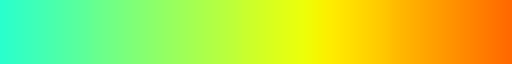

In [31]:
cmap = plt.get_cmap("jet")
trunc_cmap = truncate_colormap(cmap, 0.4, 0.8)
trunc_cmap

In [ ]:
extent=[110.99778373704645,111.56357963548395,24.461242833894357,25.129462933561904]
lon_target = np.arange(111.08795,111.515133,0.001)
lat_target = np.arange(24.593434,25.18245,0.001)
x_t, y_t = np.meshgrid(lon_target, lat_target)
# model=OrdinaryKriging(Tfc['lon'].values,Tfc['lat'].values,Tfc['T'].values,variogram_model='gaussian',nlags=100)
model=OrdinaryKriging(Tfc['lon'].values,Tfc['lat'].values,Tfc['T'].values,variogram_model='linear',nlags=50)
# model=OrdinaryKriging(fcdatadf['lon'].values,fcdatadf['lat'].values,fcdatadf['rain'].values,variogram_model='linear',nlags=1)
ds1,ds2=model.execute('grid',lon_target,lat_target)
ds1=np.round(ds1,3)

fig=plt.figure(figsize=(9,16))
ax=fig.add_axes([0.1,0.1,0.8,0.8],projection=ccrs.PlateCarree())
ax1=fig.add_axes([0.11,0.20,0.04,0.15])
ax2=fig.add_axes([0.79,0.75,0.05*(16/9),0.05])
ax2.set_axis_off()
ax3=fig.add_axes([0.59,0.195,0.18*(16/9),0.025])
ax3.set_axis_off()
# arrimg=plt.imread(r"C:\Users\Linzy\Desktop\chinaclimate.png")
arrimg=plt.imread(r"C:\Users\Linzy\Desktop\图片231201(1)(1).png")
# arrimg1=plt.imread(r"C:\Users\Linzy\Desktop\bili.png")
arrimg1=plt.imread(r"C:\Users\Linzy\Downloads\IMG_202312015885_719x126.png")
ax2.imshow(arrimg)
ax3.imshow(arrimg1)
ax.add_geometries(Reader(r"D:\_work\mapdata\fuchuan\geojson.shp").geometries(),ccrs.PlateCarree(),facecolor='none', edgecolor='b', linewidth=0.8)
color=ax.contourf(x_t,y_t,ds1,levels=np.linspace(18,21,70),cmap=trunc_cmap,transform=ccrs.PlateCarree())

for i in range(0,len(Tfc),1):
    staname=Tfc['staname'].values[i][2:-5]
    ha='left'
    if i==0:
        staname=Tfc['staname'].values[i][2:]
        ha='right'
    if i in [8,9,11]:
         staname=Tfc['staname'].values[i][2:-7]
    if i in [13]:
        ha='right'

    ax.scatter(Tfc['lon'].values[i],Tfc['lat'].values[i],color='black',transform=ccrs.PlateCarree())
    ax.text(Tfc['lon'].values[i],Tfc['lat'].values[i],staname,ha=ha,color='black',transform=ccrs.PlateCarree())


## 关键操作：生成裁剪路径
path_clip =Path.make_compound_path(*geos_to_path(shp['geometry'].to_list()))
## 关键操作：将裁剪路径应用到图层
for collection in color.collections:
    collection.set_clip_path(path_clip,transform=ax.transData)
cb=fig.colorbar(color,ticks=np.linspace(18,21,4),cax=ax1)
cb.formatter = ticker.ScalarFormatter(useMathText=False)
cb.ax.set_title('温度\n℃',fontdict={'size':10})
cb.update_ticks()
add_north(ax)
fig.savefig('./wenduFC1.png',dpi=800,facecolor='white',bbox_inches='tight')
ds1.min(),ds1.max()

<BarContainer object of 3 artists>

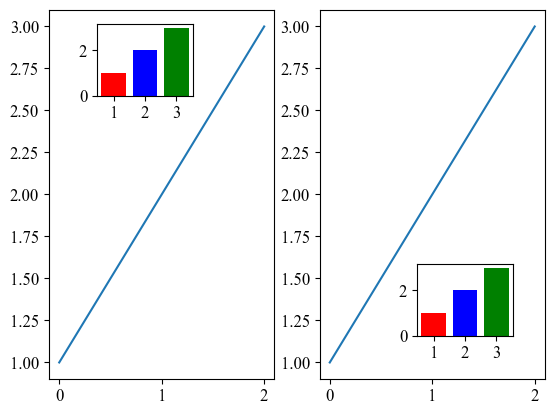

In [27]:
plt.subplots(1,2,dpi=100)
plt.subplot(121)
plt.plot([1,2,3])


plt.subplot(122)
plt.plot([1,2,3])



plt.axes([0.7, 0.2, 0.15, 0.15], ## [left, bottom, width, height]四个参数(fractions of figure)可以非常灵活的调节子图中子图的位置     
        )
plt.bar([1,2,3],[1,2,3],color=['r','b','g'])


plt.axes([0.2, 0.7, 0.15, 0.15], 
        )
plt.bar([1,2,3],[1,2,3],color=['r','b','g'])